In [1]:
import numpy as np
import os
import pathlib
import sys

if pathlib.Path(os.getcwd()).parents[2] not in sys.path:
    sys.path.append(str(pathlib.Path(os.getcwd()).parents[2]))

from Sensors.BatEcho.Spatializer import Render
from Sensors.BatEcho import Setting as sensorconfig
from Gym.BeaconDocking_v0 import Helper
from Arena import Builder

from Control.SensorimotorLoops.BatEcho import AvoidApproach
from Simulation.Motion import State
from Control.SensorimotorLoops import Setting as controlconfig

from matplotlib import pyplot as plt
%matplotlib inline

### Use docking check as docking zone function
Code:
```python
def isBatInViewBeacon(pose:np.ndarray, beacon:np.ndarray, range=BEACON_SPECS['hit_distance'], fov=BEACON_SPECS['hit_angle']):
    #alpha = np.arctan2(y-yb, x-xb)
    # phi is beacon yaw
    if r2 > np.power(range,2): return False
    if np.abs(Builder.wrap2pi(phi-alpha)) > fov/2: return False
    return True

def isBatFacingBeacon(pose:np.ndarray, beacon:np.ndarray, fov=np.pi/3):
    #alpha = np.arctan2(yb-y, xb-x)
    #beta = np.arctan2(y-yb, x-xb)
    if (np.abs(Builder.wrap2pi(yaw-alpha))+np.abs(Builder.wrap2pi(phi-beta)) > fov/2): return False
    return True

def dockingCheck(pose:np.ndarray, beacons:np.ndarray, **kwargs):
    beaconsInView = getBeaconInView(pose, beacons)
    if len(beaconsInView)<1: return False
    for beacon in beaconsInView:
        if ('beacon_range' in kwargs.keys()) and ('beacon_fov' in kwargs.keys()):
            bat_is_inView = isBatInViewBeacon(pose, beacon, range=kwargs['beacon_range'], fov=kwargs['beacon_fov'])
        else: bat_is_inView = isBatInViewBeacon(pose, beacon)
        bat_is_facing = isBatFacingBeacon(pose, beacon, fov=kwargs['facing_fov']) if 'facing_fov' in kwargs.keys() else isBatFacingBeacon(pose, beacon)
        if bat_is_facing and bat_is_inView: return True
    return False 
```


In [2]:
def isBatFacingBeacon2(pose:np.ndarray, beacon:np.ndarray, fov=np.pi/3):
    xb, yb, phi = beacon.reshape(3,)
    x, y, yaw = pose
    alpha = np.arctan2(yb-y, xb-x)
    beta = np.arctan2(y-yb, x-xb)
    if (np.abs(Builder.wrap2pi(yaw-alpha)) + np.abs(Builder.wrap2pi(phi-beta)) > fov/2): return False
    return True

def inDockingZone(pose: np.ndarray, beacons: np.ndarray, beacon_range=5., beacon_fov=np.pi/3, facing_fov=np.pi/3):
    for beacon in beacons:
        bat_is_inView = Helper.isBatInViewBeacon(pose, beacon, range=beacon_range, fov=beacon_fov)
        #if bat_is_inView: print('bat is in view')
        bat_is_facing = isBatFacingBeacon2(pose, beacon, fov=facing_fov)
        #if bat_is_facing: print('bat is facing')
        if bat_is_facing and bat_is_inView: return True
    return False 


In [3]:
def initialize_pose_set(xlim:list, ylim:list, alim:list, xstep=0.2, ystep=0.2, astep=10):
    xmin, xmax = xlim
    ymin, ymax = ylim
    amin, amax = alim
    xls = np.arange(xmin, xmax+xstep, xstep)
    yls = np.arange(ymin, ymax+ystep, ystep)
    als = np.radians(np.arange(amin, amax+astep, astep) )
    return xls, yls, als

def initialize_beacons():
    return np.asarray([0.,0.,-np.pi/2], dtype=np.float32).reshape(-1,3)


def testDockingZone(func_under_test, poses_init_func=initialize_pose_set, beacons_init_func=initialize_beacons, 
                    xlim=[-6., 6.], ylim=[-8, -.5], alim=[0., 180.]):
    xls, yls, als = poses_init_func(xlim, ylim, alim)
    beacons = beacons_init_func()
    poses = []
    c=-1
    for i, a in enumerate(als):
        for j, y in enumerate(yls):
            for k,x in enumerate(xls):
                c+=1
                pose = np.asarray([x,y,a], dtype=np.float32).reshape(3,)
                if func_under_test(pose, beacons): 
                    #print('YES')
                    poses.append(pose)
                else: pass #print('x:{:.1f}, y:{:.1f}, a:{:.1f}'.format(pose[0], pose[1], np.degrees(pose[2])))
    return np.asarray(poses).reshape(-1,3)

In [16]:
objects = Helper.beacons2objects(beacons=initialize_beacons())
poses_matrix = testDockingZone(inDockingZone)
data = np.load('data.npz')
reference_poses = data['poses']
reference_scores= data['scores']
poses_matrix_reference = reference_poses[reference_scores>0.5]
beacon_centric_reference = np.copy(poses_matrix_reference)
theta = np.pi*(-0.5)
rotmat = np.asarray([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)], dtype=np.float32).reshape(2,2)
beacon_centric_reference[:,:2] = np.matmul(rotmat, beacon_centric_reference[:,:2].T).T
beacon_centric_reference[:,2] = Builder.wrap2pi(beacon_centric_reference[:,2] + theta)

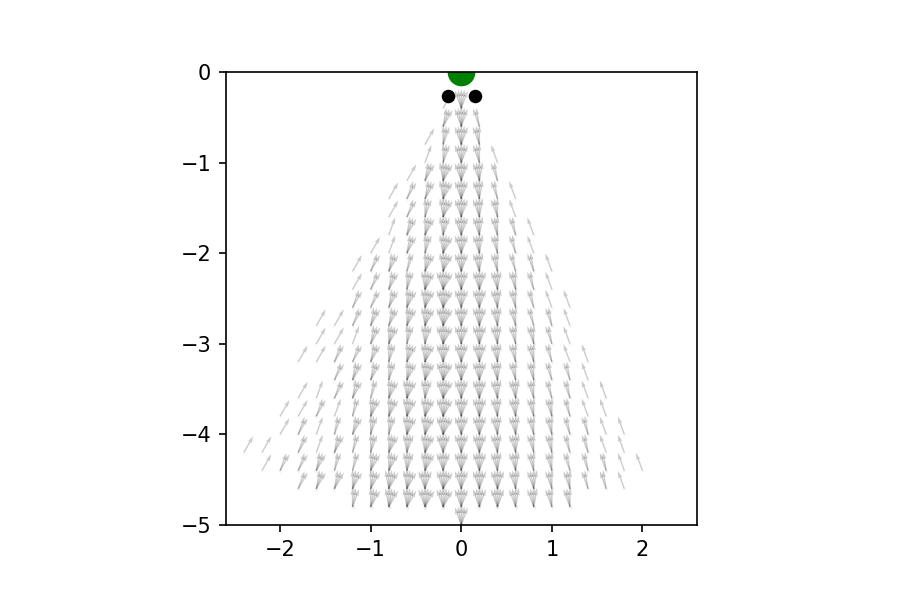

In [17]:
fig, ax = plt.subplots(dpi=150)

#ax.scatter(poses_matrix_reference[:,0],poses_matrix_reference[:,1], c='r', s=1, alpha=0.01)
#ax.quiver(poses_matrix_reference[:,0],poses_matrix_reference[:,1],
#          np.cos(poses_matrix_reference[:,2]), np.sin(poses_matrix_reference[:,2]),
#          scale=25, width=3e-3, color='r', alpha=0.1)

ax.scatter(poses_matrix[:,0],poses_matrix[:,1], c='k', s=1, alpha=0.01)
ax.quiver(poses_matrix[:,0],poses_matrix[:,1], np.cos(poses_matrix[:,2]), np.sin(poses_matrix[:,2]),
          scale=25, width=3e-3, color='k', alpha=0.2)

ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=150)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=30)
ax.set_xlim([-2.6,2.6])
ax.set_ylim([-5,0.])
ax.set_aspect('equal')

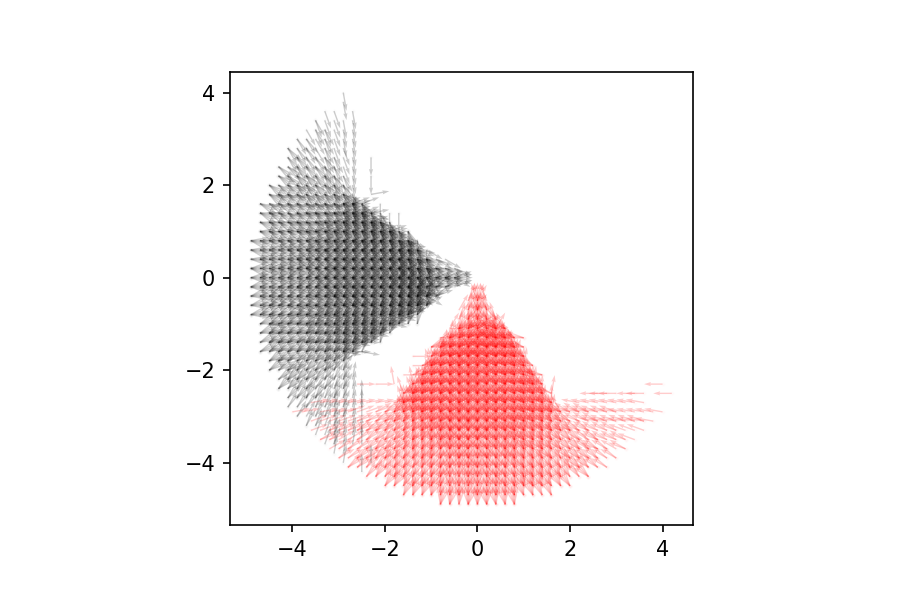

In [18]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(poses_matrix_reference[:,0],poses_matrix_reference[:,1], c='r', s=1, alpha=0.01)
ax.quiver(poses_matrix_reference[:,0],poses_matrix_reference[:,1],
        np.cos(poses_matrix_reference[:,2]), np.sin(poses_matrix_reference[:,2]),
          scale=25, width=3e-3, color='r', alpha=0.2)

ax.scatter(beacon_centric_reference[:,0],beacon_centric_reference[:,1], c='k', s=1, alpha=0.01)
ax.quiver(beacon_centric_reference[:,0],beacon_centric_reference[:,1],
        np.cos(beacon_centric_reference[:,2]), np.sin(beacon_centric_reference[:,2]),
          scale=25, width=3e-3, color='k', alpha=0.2)

#ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=150)
#ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=30)
#ax.set_xlim([-2.6,2.6])
#ax.set_ylim([-5,0.])
ax.set_aspect('equal')

(-7.0, 1.0)

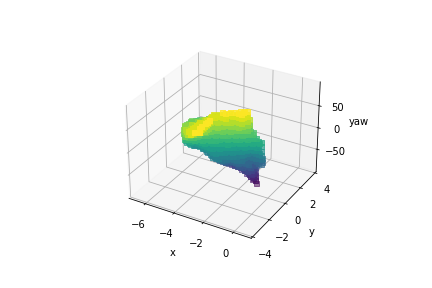

In [38]:
from mpl_toolkits import mplot3d

%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(beacon_centric_reference[:,0], beacon_centric_reference[:,1], np.degrees(beacon_centric_reference[:,2]), c=beacon_centric_reference[:,2], marker='s', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('yaw')
ax.set_ylim([-4, 4])
ax.set_xlim([-7, 1])

### To learn or not to learn
I think I should construct a train and test dataset. From this cloud.
Aparently, KNClassifier seems the most intuitive for me. However, the disadvantage is the with a large cloud of data. It will be very expensive to during runtime.
-> Let's use KNClassifier as a benchmark
Test a few candidate:
0. KNClassifer (benchmark)
1. Logistic Regression.
2. RBF SVM
3. Gaussian Process
4. Naive Bayes???

!!! Metrics:
1. Test Accuracy
2. Precision Recall
* Precision = TP/(TP + FP)
* Recall = TP/(TP + FN)
* ROC (receiver operating characteristic curve) curve (TP_rate vs FP_rate):
  * TP_rate = recall = TP/(TP+FN)
  * FP_rate = FP/(FP+TN)
  * Each point on the curve is for a threshold (or decision threshold)
  * Are under this curve indicate performance of a method despite thresholding.
* Precision recall curve: Area under this curve indicate performance.


### Metrics Functions